In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import string
from tqdm.auto import tqdm
import pickle
from sklearn import neighbors
from sklearn import metrics
from scipy import spatial
from sklearn.metrics import confusion_matrix
import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
df = pd.read_csv(r'..\data\GENDER\out_gender.csv')
label_names = ['Male', 'Female']
df['text_clean'] = ''

In [3]:
df.head()

,text,label,text_clean
0,WASHINGTON — Congressional Republicans have...,Male,
1,"The NFL needs to get its “priorities in order,...",Male,
2,"In an in the New York Times, actress Lena Du...",Male,
3,A waitress was fired after retrieving a gun fo...,Male,
4,WASHINGTON — The White House on Thursday “c...,Male,


In [4]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())  # remove multiple whitespaces
    return text

In [5]:
for i in tqdm(range(len(df))):
    df.loc[i, 'text_clean'] = clean_text(df.loc[i, 'text'])

  0%|          | 0/40666 [00:00<?, ?it/s]

In [6]:
def embed(tokens, nlp):
    """Return the centroid of the embeddings for the given tokens.

    Out-of-vocabulary tokens are cast aside. Stop words are also
    discarded. An array of 0s is returned if none of the tokens
    are valid.

    """

    lexemes = (nlp.vocab[token] for token in tokens)

    vectors = np.asarray([
        lexeme.vector
        for lexeme in lexemes
        if lexeme.has_vector
        and not lexeme.is_stop
        and len(lexeme.text) > 1
    ])

    if len(vectors) > 0:
        centroid = vectors.mean(axis=0)
    else:
        width = nlp.meta['vectors']['width']  # typically 300
        centroid = np.zeros(width)

    return centroid

In [7]:
tokens = df.loc[0, 'text_clean'].split(' ')
centroid = embed(tokens, nlp)
print(centroid.shape)
print(centroid[:10])

(300,)
[-1.0341872   0.29092434 -2.5468051   0.5357483   2.9095006   0.71387833
  0.8422483   3.4557972  -0.9317664  -0.9081056 ]


In [8]:
label_vectors = np.asarray([
    embed(label.split(' '), nlp)
    for label in label_names
])
label_vectors.shape

(2, 300)

In [9]:
neigh = neighbors.NearestNeighbors(n_neighbors=1)
neigh.fit(label_vectors)
closest_label = neigh.kneighbors([centroid], return_distance=False)[0, 0]
label_names[closest_label]

'Female'

In [10]:
def predict(doc, nlp, neigh):
    doc = clean_text(doc)
    tokens = doc.split(' ')[:50]
    centroid = embed(tokens, nlp)
    closest_label = neigh.kneighbors([centroid], return_distance=False)[0][0]
    return closest_label


preds = [label_names[predict(doc, nlp, neigh)] for doc in tqdm(df['text'])]

  0%|          | 0/40666 [00:00<?, ?it/s]

In [11]:
report = metrics.classification_report(
    y_true=df['label'],
    y_pred=preds,
    labels=label_names
)

print(report)

C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Male       0.00      0.00      0.00     18727
      Female       0.54      1.00      0.70     21939

    accuracy                           0.54     40666
   macro avg       0.27      0.50      0.35     40666
weighted avg       0.29      0.54      0.38     40666



C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'Female'), Text(0, 1.5, 'Male')]

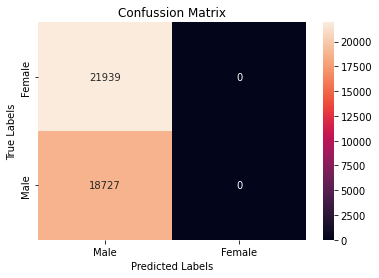

In [18]:
cm = confusion_matrix(df['label'], preds)
ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt='g', ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confussion Matrix")
ax.xaxis.set_ticklabels(['Male', 'Female']) 
ax.yaxis.set_ticklabels(['Female', 'Male'])

In [19]:
d1 = nlp
d2 = neigh

with open (r'..\models\genderModel\nlp.pkl', 'wb') as f1:
    pickle.dump(d1, f1)
with open (r'..\models\genderModel\neigh.pkl', 'wb') as f2:
    pickle.dump(d2, f2)

In [21]:
# load the model from disk
#txt = '"active", "adventurous", "aggress", "ambitio", "analy", "assert", "athlet", "autonom", "battle", "boast", "challeng", "champion", "compet", "confident", "courag", "decid", "decision", "decisive", "defend", "determin", "domina", "dominant", "driven", "fearless", "fight", "force", "greedy", "headstrong", "hierarch", "hostil", "impulsive", "independen", "individual", "intellect", "lead", "logic", "objective", "opinion", "outspoken", "persist", "principle", "reckless", "selfconfiden", "selfrelian", "selfsufficien", "stubborn", "superior", "unreasonab"'
txt = '"agree", "affectionate", "child", "cheer", "collab", "commit", "communal", "compassion", "connect", "considerate", "cooperat", "depend", "emotiona", "empath", "feel", "flatterable", "gentle", "honest", "interpersonal", "interdependen", "interpersona", "kind", "kinship", "loyal", "modesty", "nag", "nurtur", "pleasant", "polite", "quiet", "respon", "sensitiv", "submissive", "support", "sympath", "tender", "together", "trust", "understand", "warm", "whin", "enthusias", "inclusive", "yield", "share", "sharin"'

with open(r'..\models\genderModel\nlp.pkl', 'rb') as f1:
    nlp_load = pickle.load(f1)

with open(r'..\models\genderModel\neigh.pkl', 'rb') as f2:
    neigh_load = pickle.load(f2)

predict(txt, nlp_load, neigh_load)

1